In [ ]:
!pip install yfinance
!pip install torchsummaryX
!pip install wandb -q

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 544 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 33.9 MB/s 
     |████████████████████████████████| 182 kB 77.7 MB/s 
     |████████████████████████████████| 168 kB 66.7 MB/s 
     |████████████████████████████████| 62 kB 1.7 MB/s 
     |████████████████████████████████| 140 kB 76.7 MB/s 


In [ ]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
import time
import os
import yfinance as yf
import pandas as pd
import datetime
import torch
import torch.nn as nn
from torchsummaryX import summary
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import gc

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.getcwd()

Mounted at /content/drive


'/content'

In [ ]:
import wandb
wandb.login(key="03916b709446813b51f72a1b29a2854a9dd9e3f7")

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# Training Config
config = {
    "batch_size" : 32,
    "lr" : 1e-3,
    "epochs" : 100,
    "look_back" : 60,
    "feature_dim" : 1,
    "hidden_dim" : 64,
    "output_dim" : 1,
    "num_layers" : 3,
    "dropout" : 0.2
}

In [ ]:
# load all that we need
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 150)

class VolatiltiyData:

    def __init__(self, tickers, start_year, start_month, start_date, end_year,
                 end_month, end_date, freq, scaling_factor, windows, y_window):
        self.tickers = tickers
        self.start = datetime.datetime(start_year, start_month, start_date)
        self.end = datetime.datetime(end_year, end_month, end_date)
        self.freq = freq
        self.scaling_factor = scaling_factor
        # 过去几天的vol
        self.windows = windows
        # Predict几天的vol
        self.y_window = y_window 

    def get_data(self):
        """
        Output:
        raw data -> ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Log Adj Close', 'Log Return', 10-day-vol']
        """
        data = yf.download(self.tickers, start = self.start, end = self.end, interval = self.freq)
        data["Log Adj Close"] = np.log(data["Adj Close"])
        data["Log Return"] = np.insert(np.diff(data["Log Adj Close"]), 0, 0) * 100
        data["10-day-vol"] = data["Log Return"].rolling(10).std(ddof=0)
        return data
    
    def prepare_data(self, data):
        """
        Prepare data for training. Select features that are needed. Perform necessary normalization.
        
        For volatiltiy data, we need to remove initial n days since we need at least n days to calculate volatiltiy.

        Output:
        dataset ->  (samples, features)
        scalar  ->  scalar for our normalization
        """
        vol_10 = data['10-day-vol'].values
        dataset = vol_10.reshape(-1, 1)[11:]
        
        # normalize the dataset
        scaler = MinMaxScaler(feature_range=(0, 1))
        dataset = scaler.fit_transform(dataset)
        return dataset, scaler

volatiltiy_data = VolatiltiyData(
                      "^GSPC",
                      1990, 1, 2,
                      2022, 12, 12,
                      freq="1d",
                      scaling_factor=100,
                      windows=[10], # 过去几天的vol
                      y_window=10 # Predict几天的vol
                  )

data = volatiltiy_data.get_data()
dataset, scaler = volatiltiy_data.prepare_data(data)
print(np.shape(dataset))

[*********************100%***********************]  1 of 1 completed
(8290, 1)


In [ ]:
class DataLoaderForVolatilityModeling(DataLoader):
    """
    Construct dataloader
  
    The label for our data is the next 10-day volatility after our input.

    Output:
    input -> (batch_size, seq_len, feature_size)
    label -> (batch_size, 1, feature_size) 
    """
    def __init__(self, dataset, batch_size, sequence_length, shuffle=True, feature_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.sequence_length = sequence_length
        self.num_batches = (np.shape(self.dataset)[0]-10) // self.batch_size
        self.feature_size = feature_size

    def __len__(self):
        return self.num_batches - self.sequence_length

    def __iter__(self):
        # group the sequence into batches
        x = torch.from_numpy(np.reshape(self.dataset[:self.num_batches*self.batch_size, :], (self.batch_size, -1))).type(torch.float32)
        y = torch.from_numpy(np.reshape(self.dataset[10:self.num_batches*self.batch_size+10, :], (self.batch_size, -1))).type(torch.float32)

        # return a tuple of (input, label) on every iteration with yield
        index = 0
        while index+self.sequence_length < self.num_batches:
            time_steps = self.sequence_length
            input = x[:, index:index+time_steps].view(self.batch_size, time_steps, self.feature_size)
            label = y[:, index+time_steps].view(self.batch_size, self.feature_size)
            index += 1
            yield input, label

In [ ]:
# sanity check
dataloader = DataLoaderForVolatilityModeling(dataset, batch_size=config["batch_size"], sequence_length=config["look_back"])
tmp = iter(dataloader)
input, label = next(tmp)
print(f'input shape = {np.shape(input)}')
print(f'label shape = {np.shape(label)}')

input shape = torch.Size([32, 60, 1])
label shape = torch.Size([32, 1])


In [ ]:
# model
class Model(nn.Module):
    """
    Construct model architecture
    """
    def __init__(self, feature_dim, hidden_dim, output_dim):
        super(Model, self).__init__()
        self.lstm = torch.nn.LSTM(input_size=feature_dim, hidden_size=hidden_dim, num_layers=config["num_layers"], dropout=config["dropout"], batch_first=True)
        self.relu = torch.nn.ReLU()
        self.linear = torch.nn.Linear(in_features=hidden_dim, out_features=output_dim, bias=True)

    def forward(self, x):
        x, h = self.lstm(x)
        x = x[:, -1, :]
        x = self.relu(x)
        x = self.linear(x)
        return x

In [ ]:
# sanity check
torch.cuda.empty_cache()

model = Model(config['feature_dim'], config['hidden_dim'], config['output_dim']).to(device)
prediction = model(input.to(device))
print(f'shape of prediction : {prediction.shape}')
print(f'shape of label : {label.shape}')

summary(model, input.to(device))

shape of prediction : torch.Size([32, 1])
shape of label : torch.Size([32, 1])
         Kernel Shape  Output Shape    Params Mult-Adds
Layer                                                  
0_lstm              -  [32, 60, 64]  150.272k  147.712k
1_relu              -      [32, 64]         -         -
2_linear      [64, 1]       [32, 1]      65.0      64.0
--------------------------------------------------------
                        Totals
Total params          150.337k
Trainable params      150.337k
Non-trainable params       0.0
Mult-Adds             147.776k


/usr/local/lib/python3.8/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_sum = df.sum()


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_lstm,-,"[32, 60, 64]",150272.0,147712.0
1_relu,-,"[32, 64]",NaN,NaN
2_linear,"[64, 1]","[32, 1]",65.0,64.0


In [ ]:
# Prepare loader
train_size = int(len(dataset) * 0.5)
val_size = int(len(dataset) * 0.2)
test_size = len(dataset) - train_size - val_size
train_data, val_data, test_data = dataset[0:train_size,:], dataset[train_size:train_size+val_size,:], dataset[train_size+val_size:len(dataset),:]

train_loader = DataLoaderForVolatilityModeling(train_data, batch_size=config['batch_size'], sequence_length=config['look_back'], shuffle=True)
val_loader = DataLoaderForVolatilityModeling(val_data, batch_size=10, sequence_length=config['look_back'], shuffle=False)
test_loader = DataLoaderForVolatilityModeling(test_data, batch_size=1, sequence_length=config['look_back'], shuffle=False)

# Prepare optimizer, criterion, and scheduler_lr
optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'], weight_decay = 5e-5) # What goes in here?
criterion = torch.nn.MSELoss()
scheduler_lr = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.75, patience=2, verbose=True)

In [ ]:
# Evaluate
def evaluate(val_loader, model, criterion):
    model.eval()

    batch_bar = tqdm(total=len(val_loader), dynamic_ncols=True, position=0, leave=False, desc="Val")

    val_loss = 0

    for i, (input, target) in enumerate(val_loader):

        input, target = input.to(device), target.to(device)

        with torch.inference_mode():
            prediction = model(input)

        loss = criterion(prediction.flatten(), target.flatten())

        val_loss += loss.item()
        # print(loss.item())

        batch_bar.set_postfix(
            loss = f"{val_loss/ (i+1):.4f}",
            lr = f"{curr_lr}"
        )

        batch_bar.update()

        torch.cuda.empty_cache()
        del input
        del target

    batch_bar.close()
    val_loss /= len(dataloader)

    return val_loss

In [ ]:
# Train Step
def train_step(train_loader, model, optimizer, criterion):
    batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
    train_loss = 0
    model.train()

    for i, (input, target) in enumerate(train_loader):
        input, target = input.to(device), target.to(device)
        curr_lr = optimizer.param_groups[0]['lr']

        optimizer.zero_grad()
        prediction = model(input)
        # print(f'prediction : {prediction}')
        # print(f'target : {target}')
        loss = criterion(prediction.flatten(), target.flatten())
        # print(f'loss : {loss.item()}')

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        batch_bar.set_postfix(
            loss = f"{train_loss/ (i+1):.4f}",
            lr = f"{curr_lr}"
        )

        batch_bar.update()

        torch.cuda.empty_cache()
        del input
        del target
    
    batch_bar.close()
    train_loss /= len(train_loader)
    
    return train_loss

In [ ]:
# Initialize wandb
run = wandb.init(
    name = "LSTM_arch", ## Wandb creates random run names if you skip this field
    reinit = True, ### Allows reinitalizing runs when you re-run this cell
    # run_id = ### Insert specific run id here if you want to resume a previous run
    # resume = "must" ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "10701_Volatility_Prediction", ### Project should be created in your wandb account 
    config = config ### Wandb Config for your run
)

In [ ]:
best_val_loss = 100

# Train loop
torch.cuda.empty_cache()
gc.collect()

train_loss, val_loss = 0, 0

for epoch in range(config["epochs"]):
    
    curr_lr = optimizer.param_groups[0]['lr']

    train_loss = train_step(train_loader, model, optimizer, criterion)

    val_loss = evaluate(val_loader, model, criterion)

    scheduler_lr.step(train_loss)

    print("\nEpoch {}/{}: \n\t Train Loss {:.07f}\t Eval Loss {:.07f}\t Learning Rate {:.04f}\t".format(
          epoch + 1,
          config['epochs'],
          train_loss,
          val_loss,
          curr_lr))
    
    wandb.log({"train_loss":train_loss, 'val_loss': val_loss, "learning_Rate": curr_lr})
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        path = '/content/drive/MyDrive/10701/checkpoint/checkpoint_eval_loss_bidrectional'
        torch.save({'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler': scheduler_lr.state_dict(),
                    'val_loss': val_loss, 
                    'epoch': epoch}, path)
wandb.save(path)
run.finish()


Epoch 1/100: 
	 Train Loss 0.0049412	 Eval Loss 0.0111164	 Learning Rate 0.0010	



Epoch 2/100: 
	 Train Loss 0.0029406	 Eval Loss 0.0048825	 Learning Rate 0.0010	



Epoch 3/100: 
	 Train Loss 0.0017963	 Eval Loss 0.0035530	 Learning Rate 0.0010	



Epoch 4/100: 
	 Train Loss 0.0018398	 Eval Loss 0.0033817	 Learning Rate 0.0010	



Epoch 5/100: 
	 Train Loss 0.0014624	 Eval Loss 0.0036848	 Learning Rate 0.0010	



Epoch 6/100: 
	 Train Loss 0.0012858	 Eval Loss 0.0020903	 Learning Rate 0.0010	



Epoch 7/100: 
	 Train Loss 0.0009778	 Eval Loss 0.0018061	 Learning Rate 0.0010	



Epoch 8/100: 
	 Train Loss 0.0009140	 Eval Loss 0.0020358	 Learning Rate 0.0010	



Epoch 9/100: 
	 Train Loss 0.0008886	 Eval Loss 0.0022264	 Learning Rate 0.0010	



Epoch 10/100: 
	 Train Loss 0.0008681	 Eval Loss 0.0018878	 Learning Rate 0.0010	



Epoch 11/100: 
	 Train Loss 0.0008388	 Eval Loss 0.0021594	 Learning Rate 0.0010	



Epoch 12/100: 
	 Train Loss 0.0007907	 Eval Loss 0.0020784	 Learning Rate 0.0010	



Epoch 13/100: 
	 Train Loss 0.0007964	 Eval Loss 0.0016664	 Learning Rate 0.0010	



Epoch 14/100: 
	 Train Loss 0.0007571	 Eval Loss 0.0020204	 Learning Rate 0.0010	



Epoch 15/100: 
	 Train Loss 0.0007093	 Eval Loss 0.0018307	 Learning Rate 0.0010	



Epoch 16/100: 
	 Train Loss 0.0006968	 Eval Loss 0.0018658	 Learning Rate 0.0010	



Epoch 17/100: 
	 Train Loss 0.0007106	 Eval Loss 0.0022103	 Learning Rate 0.0010	



Epoch 18/100: 
	 Train Loss 0.0006719	 Eval Loss 0.0018936	 Learning Rate 0.0010	



Epoch 19/100: 
	 Train Loss 0.0006953	 Eval Loss 0.0020686	 Learning Rate 0.0010	



Epoch 20/100: 
	 Train Loss 0.0006348	 Eval Loss 0.0017440	 Learning Rate 0.0010	



Epoch 21/100: 
	 Train Loss 0.0006389	 Eval Loss 0.0016774	 Learning Rate 0.0010	



Epoch 22/100: 
	 Train Loss 0.0006006	 Eval Loss 0.0019758	 Learning Rate 0.0010	



Epoch 23/100: 
	 Train Loss 0.0005791	 Eval Loss 0.0017935	 Learning Rate 0.0010	



Epoch 24/100: 
	 Train Loss 0.0006057	 Eval Loss 0.0016946	 Learning Rate 0.0010	



Epoch 25/100: 
	 Train Loss 0.0005706	 Eval Loss 0.0020362	 Learning Rate 0.0010	



Epoch 26/100: 
	 Train Loss 0.0006022	 Eval Loss 0.0020492	 Learning Rate 0.0010	



Epoch 27/100: 
	 Train Loss 0.0006119	 Eval Loss 0.0019124	 Learning Rate 0.0010	


Epoch 00028: reducing learning rate of group 0 to 7.5000e-04.

Epoch 28/100: 
	 Train Loss 0.0005768	 Eval Loss 0.0020230	 Learning Rate 0.0010	



Epoch 29/100: 
	 Train Loss 0.0005660	 Eval Loss 0.0015527	 Learning Rate 0.0008	



Epoch 30/100: 
	 Train Loss 0.0005492	 Eval Loss 0.0014142	 Learning Rate 0.0008	



Epoch 31/100: 
	 Train Loss 0.0005352	 Eval Loss 0.0016304	 Learning Rate 0.0008	



Epoch 32/100: 
	 Train Loss 0.0005228	 Eval Loss 0.0015677	 Learning Rate 0.0008	



Epoch 33/100: 
	 Train Loss 0.0005299	 Eval Loss 0.0017866	 Learning Rate 0.0008	



Epoch 34/100: 
	 Train Loss 0.0005390	 Eval Loss 0.0015088	 Learning Rate 0.0008	


Epoch 00035: reducing learning rate of group 0 to 5.6250e-04.

Epoch 35/100: 
	 Train Loss 0.0005299	 Eval Loss 0.0016843	 Learning Rate 0.0008	



Epoch 36/100: 
	 Train Loss 0.0005153	 Eval Loss 0.0015547	 Learning Rate 0.0006	



Epoch 37/100: 
	 Train Loss 0.0004833	 Eval Loss 0.0016804	 Learning Rate 0.0006	



Epoch 38/100: 
	 Train Loss 0.0005095	 Eval Loss 0.0016335	 Learning Rate 0.0006	



Epoch 39/100: 
	 Train Loss 0.0004920	 Eval Loss 0.0017148	 Learning Rate 0.0006	



Epoch 40/100: 
	 Train Loss 0.0004801	 Eval Loss 0.0016086	 Learning Rate 0.0006	



Epoch 41/100: 
	 Train Loss 0.0004956	 Eval Loss 0.0016633	 Learning Rate 0.0006	



Epoch 42/100: 
	 Train Loss 0.0004968	 Eval Loss 0.0016109	 Learning Rate 0.0006	


Epoch 00043: reducing learning rate of group 0 to 4.2188e-04.

Epoch 43/100: 
	 Train Loss 0.0004828	 Eval Loss 0.0017585	 Learning Rate 0.0006	



Epoch 44/100: 
	 Train Loss 0.0004889	 Eval Loss 0.0018899	 Learning Rate 0.0004	



Epoch 45/100: 
	 Train Loss 0.0004734	 Eval Loss 0.0019537	 Learning Rate 0.0004	



Epoch 46/100: 
	 Train Loss 0.0004846	 Eval Loss 0.0017901	 Learning Rate 0.0004	



Epoch 47/100: 
	 Train Loss 0.0004738	 Eval Loss 0.0017631	 Learning Rate 0.0004	


Epoch 00048: reducing learning rate of group 0 to 3.1641e-04.

Epoch 48/100: 
	 Train Loss 0.0004746	 Eval Loss 0.0017677	 Learning Rate 0.0004	



Epoch 49/100: 
	 Train Loss 0.0004531	 Eval Loss 0.0017467	 Learning Rate 0.0003	



Epoch 50/100: 
	 Train Loss 0.0004646	 Eval Loss 0.0017181	 Learning Rate 0.0003	



Epoch 51/100: 
	 Train Loss 0.0004579	 Eval Loss 0.0017282	 Learning Rate 0.0003	


Epoch 00052: reducing learning rate of group 0 to 2.3730e-04.

Epoch 52/100: 
	 Train Loss 0.0004613	 Eval Loss 0.0018942	 Learning Rate 0.0003	



Epoch 53/100: 
	 Train Loss 0.0004501	 Eval Loss 0.0019010	 Learning Rate 0.0002	



Epoch 54/100: 
	 Train Loss 0.0004638	 Eval Loss 0.0018794	 Learning Rate 0.0002	



Epoch 55/100: 
	 Train Loss 0.0004479	 Eval Loss 0.0018563	 Learning Rate 0.0002	



Epoch 56/100: 
	 Train Loss 0.0004423	 Eval Loss 0.0019274	 Learning Rate 0.0002	



Epoch 57/100: 
	 Train Loss 0.0004514	 Eval Loss 0.0017874	 Learning Rate 0.0002	



Epoch 58/100: 
	 Train Loss 0.0004410	 Eval Loss 0.0018779	 Learning Rate 0.0002	



Epoch 59/100: 
	 Train Loss 0.0004476	 Eval Loss 0.0018481	 Learning Rate 0.0002	



Epoch 60/100: 
	 Train Loss 0.0004399	 Eval Loss 0.0019388	 Learning Rate 0.0002	



Epoch 61/100: 
	 Train Loss 0.0004384	 Eval Loss 0.0018120	 Learning Rate 0.0002	



Epoch 62/100: 
	 Train Loss 0.0004571	 Eval Loss 0.0019868	 Learning Rate 0.0002	



Epoch 63/100: 
	 Train Loss 0.0004456	 Eval Loss 0.0020074	 Learning Rate 0.0002	


Epoch 00064: reducing learning rate of group 0 to 1.7798e-04.

Epoch 64/100: 
	 Train Loss 0.0004435	 Eval Loss 0.0018719	 Learning Rate 0.0002	



Epoch 65/100: 
	 Train Loss 0.0004351	 Eval Loss 0.0018607	 Learning Rate 0.0002	



Epoch 66/100: 
	 Train Loss 0.0004285	 Eval Loss 0.0018728	 Learning Rate 0.0002	



Epoch 67/100: 
	 Train Loss 0.0004368	 Eval Loss 0.0018750	 Learning Rate 0.0002	



Epoch 68/100: 
	 Train Loss 0.0004433	 Eval Loss 0.0019590	 Learning Rate 0.0002	



Epoch 69/100: 
	 Train Loss 0.0004267	 Eval Loss 0.0019004	 Learning Rate 0.0002	



Epoch 70/100: 
	 Train Loss 0.0004321	 Eval Loss 0.0018937	 Learning Rate 0.0002	



Epoch 71/100: 
	 Train Loss 0.0004224	 Eval Loss 0.0018551	 Learning Rate 0.0002	



Epoch 72/100: 
	 Train Loss 0.0004322	 Eval Loss 0.0018734	 Learning Rate 0.0002	



Epoch 73/100: 
	 Train Loss 0.0004256	 Eval Loss 0.0018255	 Learning Rate 0.0002	


Epoch 00074: reducing learning rate of group 0 to 1.3348e-04.

Epoch 74/100: 
	 Train Loss 0.0004256	 Eval Loss 0.0019019	 Learning Rate 0.0002	



Epoch 75/100: 
	 Train Loss 0.0004502	 Eval Loss 0.0020013	 Learning Rate 0.0001	



Epoch 76/100: 
	 Train Loss 0.0004293	 Eval Loss 0.0017965	 Learning Rate 0.0001	


Epoch 00077: reducing learning rate of group 0 to 1.0011e-04.

Epoch 77/100: 
	 Train Loss 0.0004463	 Eval Loss 0.0018499	 Learning Rate 0.0001	



Epoch 78/100: 
	 Train Loss 0.0004308	 Eval Loss 0.0018655	 Learning Rate 0.0001	



Epoch 79/100: 
	 Train Loss 0.0004342	 Eval Loss 0.0018223	 Learning Rate 0.0001	


Epoch 00080: reducing learning rate of group 0 to 7.5085e-05.

Epoch 80/100: 
	 Train Loss 0.0004278	 Eval Loss 0.0019000	 Learning Rate 0.0001	



Epoch 81/100: 
	 Train Loss 0.0004257	 Eval Loss 0.0018571	 Learning Rate 0.0001	



Epoch 82/100: 
	 Train Loss 0.0004215	 Eval Loss 0.0018807	 Learning Rate 0.0001	



Epoch 83/100: 
	 Train Loss 0.0004183	 Eval Loss 0.0018451	 Learning Rate 0.0001	



Epoch 84/100: 
	 Train Loss 0.0004306	 Eval Loss 0.0018454	 Learning Rate 0.0001	



Epoch 85/100: 
	 Train Loss 0.0004384	 Eval Loss 0.0018766	 Learning Rate 0.0001	


Epoch 00086: reducing learning rate of group 0 to 5.6314e-05.

Epoch 86/100: 
	 Train Loss 0.0004252	 Eval Loss 0.0018497	 Learning Rate 0.0001	



Epoch 87/100: 
	 Train Loss 0.0004289	 Eval Loss 0.0018684	 Learning Rate 0.0001	



Epoch 88/100: 
	 Train Loss 0.0004188	 Eval Loss 0.0018317	 Learning Rate 0.0001	



Epoch 89/100: 
	 Train Loss 0.0004173	 Eval Loss 0.0018431	 Learning Rate 0.0001	



Epoch 90/100: 
	 Train Loss 0.0004195	 Eval Loss 0.0017967	 Learning Rate 0.0001	



Epoch 91/100: 
	 Train Loss 0.0004354	 Eval Loss 0.0018130	 Learning Rate 0.0001	


Epoch 00092: reducing learning rate of group 0 to 4.2235e-05.

Epoch 92/100: 
	 Train Loss 0.0004258	 Eval Loss 0.0018412	 Learning Rate 0.0001	



Epoch 93/100: 
	 Train Loss 0.0004212	 Eval Loss 0.0018667	 Learning Rate 0.0000	



Epoch 94/100: 
	 Train Loss 0.0004234	 Eval Loss 0.0018465	 Learning Rate 0.0000	



Epoch 95/100: 
	 Train Loss 0.0004129	 Eval Loss 0.0018181	 Learning Rate 0.0000	



Epoch 96/100: 
	 Train Loss 0.0004240	 Eval Loss 0.0017931	 Learning Rate 0.0000	



Epoch 97/100: 
	 Train Loss 0.0004095	 Eval Loss 0.0018048	 Learning Rate 0.0000	



Epoch 98/100: 
	 Train Loss 0.0004175	 Eval Loss 0.0017977	 Learning Rate 0.0000	



Epoch 99/100: 
	 Train Loss 0.0004116	 Eval Loss 0.0017779	 Learning Rate 0.0000	


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Epoch 00100: reducing learning rate of group 0 to 3.1676e-05.

Epoch 100/100: 
	 Train Loss 0.0004180	 Eval Loss 0.0017340	 Learning Rate 0.0000	


wandb: ERROR Control-C detected -- Run data was not synced


In [ ]:
state_dict = torch.load(path)
model.load_state_dict(state_dict['model_state_dict'])

<All keys matched successfully>

In [ ]:
# Prediction
def predict(test_loader, model):
    model.eval()
    preds, targets = [], []
    test_loss = 0

    for i, (input, target) in enumerate(test_loader):

        input, target = input.to(device), target.to(device)

        with torch.inference_mode():
            prediction = model(input)

        test_loss += criterion(prediction.flatten(), target.flatten())

        # Note: Each loaded data is a column
        prediction = prediction.cpu().detach().numpy() # (batch_size, feature_size)
        target = target.cpu().detach().numpy() # (batch_size, feature_size)

        preds.append(prediction.flatten()[0])
        targets.append(target.flatten()[0])

        del input
        del target
    
    test_loss /= len(test_loader)

    return preds, targets, test_loss

In [ ]:
torch.cuda.empty_cache()
gc.collect()

preds, targets, test_loss = predict(test_loader, model)

loss = 'Eval loss : {:.07}'.format(best_val_loss)
print(loss)

loss = 'Test loss : {:.07}'.format(test_loss)
print(loss)

Eval loss : 0.001414238
Test loss : 0.001479225


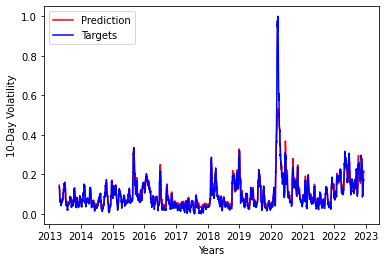

In [ ]:
df = data.copy()
df = df.tail(len(preds))
df.drop(df.columns, inplace=True, axis=1)
df['preds'] = preds

# Generate output
plt.plot(df.index, preds, label="Prediction", color="red")
plt.plot(df.index, targets, label="Targets", color="blue")
plt.xlabel("Years")
plt.ylabel("10-Day Volatility")
plt.legend(loc="upper left")
plt.show()

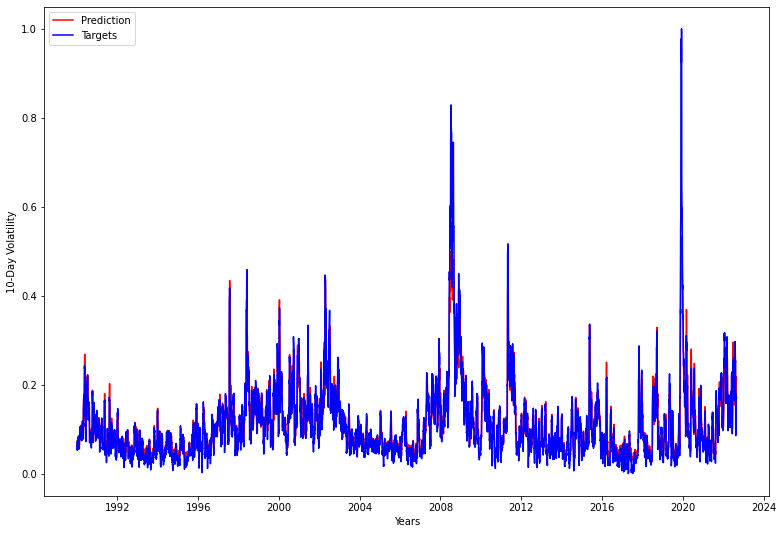

Eval loss : 0.001414238
Test loss : 0.001074385


In [ ]:
# Prediction for the entire dataset
data_loader = DataLoaderForVolatilityModeling(dataset, batch_size=1, sequence_length=config['look_back'], shuffle=False)

# Make predictions
preds, targets, test_loss = predict(data_loader, model)

# Generate output
plt.figure(figsize=(13,9))
plt.plot(data.index[:len(preds)], preds, label="Prediction", color="red")
plt.plot(data.index[:len(targets)], targets, label="Targets", color="blue")
plt.xlabel("Years")
plt.ylabel("10-Day Volatility")
plt.legend(loc="upper left")
plt.show()

loss = 'Eval loss : {:.07}'.format(best_val_loss)
print(loss)

loss = 'Test loss : {:.07}'.format(test_loss)
print(loss)